<a href="https://colab.research.google.com/github/SlowlyFire/ImageProcessingEx4/blob/main/Copy_of_ImageProcessingEx_04_EdgeDetection_HoughTransform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Processing Assignment 4: Edge Detection and Hough Transform

Before we start, please put your names and IDs in following format

: Firstname LASTNAME, #00000000   //   (e.g.) Dana LEVI, #12345678

**Your Answer:**   
Gal Giladi, #312491616  
Ori Angel, #314617739

In this exercise, you will implement the **Edge Detection** and the  **Hough Transform** algorithms.

Methods: as explained in class.

Notes:
*   Write your code in the dedicated areas (TODO blocks). You can add helper functions.
*   Submission email should include a link to the Colab submission notebook located on your Google Drive with Commenter access right to nev1958a@gmail.com
*   The solution notebook should be able to be run (‘Run all’) with no errors.
In case of errors, the submission will be disqualified.
*   The grade will depend on correct performance on several grayscale images and on clean programming and documentation.
*   Do not forget to add the Names and Student I.D. at the top of the notebook.
*   All images are given as 2-dimensional matrices of type `float`, with values in the range [0..1].
*   Pay Attention! In the following functions, the returned images must be the same size as the original Images!

Please implement the following functions:
1. Write the `edge_detect` function which finds the edges using the Canny Edge Detector. Remember to first smooth the image. The input of the function is a grayscale image The output should be a binary image with only the edges(matrix  with zeros and ones), and the `tg_theta` (matrix of the tangent of the gradient angle). You should use the hysteresis threshold (`t_high`, `t_low` thresholds).
2. Write the `find_circles` function which finds circles in the given grayscale image using Hough transform. The function should print the list of circles in this image and return it as a matrix where each row represent a circle and contains 3 values: `origin_x`, `origin_y` and `radius`. In addition, the function should return an image (`img_c`) which contains the original image and the marked circles (draw the circles which you have found on the original image). **This function should use the previous `edge_detect` function on the given image before performing the Hough transform.**
 - **Remember to use the `tg_theta` to improve the complexity of the algorithm!**

**Note** In these images, **1** represents the object, and **0** (black) represents the background.

**Note** You should make sure the function work on `balls4.tiff`.

## Setup Code
Before getting started, we need to run some boilerplate code to set up our environment. You will need to rerun this setup code each time you start the notebook.

In [162]:
import os
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import PIL
from scipy.signal import convolve

In [163]:
GITHUB_PATH = 'https://raw.githubusercontent.com/dnevo/ImageProcessing/main/images/'

In [164]:
def read_file(file_name:str, file_path:str=GITHUB_PATH) -> np.ndarray:
    '''
    Accept an image file name (defaulty located in GitHub) and return the image
    in a numpy array.

    Args:
        file_name: the file name
        file_path: the file path.. Default value is Doron's Github repo.

    Returns:
        the image converted into a Numpy array.
    '''
    file_path = os.path.join(file_path, file_name)
    response = requests.get(file_path)
    fp = BytesIO(response.content)

    img_pil = PIL.Image.open(fp)
    return np.array(img_pil, dtype='int16')

In [165]:
def plot_images(img1:np.array, img2:np.array):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    axes[0].imshow(img1,  cmap='gray')
    axes[1].imshow(img2,  cmap='gray')

## `edge_detect`

In [166]:
def edge_detect(img: np.array, t_low: np.float32, t_high: np.float32) \
    -> (np.array, np.array):
    '''
    This function receives a grayscale image and locate its edges using the
    Canny Edge Detector algorithm.

    Args:
        img:    image array in float format (range: 0..1) - the source grayscale
                image.
        t_low:  float format (range: 0..1), the Low threshold value.
        t_high: float format (range: 0..1), the High threshold value.

    Returns:
        img_e:    array in int format (values: 0, 1) - binary image with edges
                    pixels set to 1.
        tg_theta: array in float format (range: 0..1) - the matrix of the
                    tangents of the gradients angles.
    '''
    # Copy of the img, so we dont ruin the original img
    new_img = img.copy()
    # Smoothing / noise reduction - using guassian filter
    gaussian_conv = np.array([[1/16, 2/16, 1/16],
                              [2/16, 4/16, 2/16],
                              [1/16, 2/16, 1/16]])

    # Get the dimensions of the image
    rows, cols = new_img.shape


    # Loop through every pixel
    for i in range(1, rows-2):  # avoid border pixels to ensure kernel fits
        for j in range(1, cols-2):
            # Apply the Gaussian convolution operation to the current pixel and its neighbors
            new_pixel_value = (img[i-1, j-1] * gaussian_conv[0, 0] +
                              img[i-1, j] * gaussian_conv[0, 1] +
                              img[i-1, j+1] * gaussian_conv[0, 2] +
                              img[i, j-1] * gaussian_conv[1, 0] +
                              img[i, j] * gaussian_conv[1, 1] +
                              img[i, j+1] * gaussian_conv[1, 2] +
                              img[i+1, j-1] * gaussian_conv[2, 0] +
                              img[i+1, j] * gaussian_conv[2, 1] +
                              img[i+1, j+1] * gaussian_conv[2, 2])

            # Update the corresponding pixel in the new image
            new_img[i, j] = new_pixel_value

    Sx = convolve(new_img, np.array([[1,-1]]), 'same')
    Sy = convolve(new_img, np.array([[1,-1]]).T, 'same')
    S = np.sqrt(Sx*Sx + Sy*Sy)

    # Create the gradient matrix, initialized to zeros
    img_e = np.zeros((rows, cols))

    # Pass1 - loop through every pixel of S, and use thresholding (from top-left to bottom-right)
    for i in range(1, rows-2):
        for j in range(1, cols-2):
              if S[i,j] < t_low: img_e[i,j] = 0
              elif S[i,j] > t_high: img_e[i,j] = 1
              elif np.any(img_e[i-1:i+2, j-1:j+2]) == 1 : img_e[i,j] = 1
              else: img_e[i,j] = 0

    # Pass2 - loop through every pixel of S, and use thresholding ( from bottom-right to top-left)
    for i in range(rows-2, 1, -1):
        for j in range(cols-2, 1, -1):
              if S[i,j] < t_low: img_e[i,j] = 0
              elif S[i,j] > t_high: img_e[i,j] = 1
              elif np.any(img_e[i-1:i+2, j-1:j+2]) == 1 : img_e[i,j] = 1
              else: img_e[i,j] = 0

    # Avoid zero division in Sx matrix (do 0 -> 0.0001)
    for i in range(rows):
      for j in range(cols):
        if Sx[i,j] == 0:
          Sx[i,j] = 0.0001

    # Create the tg_theta matrix
    tg_theta = Sy / Sx

    # Create grad_dir - matrix with size of img, filled with zeros
    grad_dir = np.zeros((rows, cols))

    # Scan tg_theta
    for i in range(1, rows-2):
      for j in range(1, cols-2):
            if -0.4142 <= tg_theta[i, j] <= 0.4142: grad_dir[i, j] = 1
            if  0.4142 <  tg_theta[i, j] <= 2.4142: grad_dir[i, j] = 2
            if            tg_theta[i, j] >  2.4142: grad_dir[i, j] = 3
            if -2.4142 <= tg_theta[i, j] < -0.4142: grad_dir[i, j] = 4

    # Print("this is grad_dir:\n", grad_dir)

    # Scan img_e
    for r in range(1, rows-2):
      for c in range(1, cols-2):
            if img_e[r, c] == 0: continue
            if grad_dir[r, c] == 1:
                if S[r, c] < max(S[r  ,c-1], S[r  ,c+1]): img_e[r, c] = 0
            if grad_dir[r, c] == 2:
                if S[r, c] < max(S[r-1,c-1], S[r+1,c+1]): img_e[r, c] = 0
            if grad_dir[r, c] == 3:
                if S[r, c] < max(S[r-1,c  ], S[r+1,c  ]): img_e[r, c] = 0
            if grad_dir[r, c] == 4:
                if S[r, c] < max(S[r-1,c+1], S[r+1,c-1]): img_e[r, c] = 0

    return img_e, tg_theta

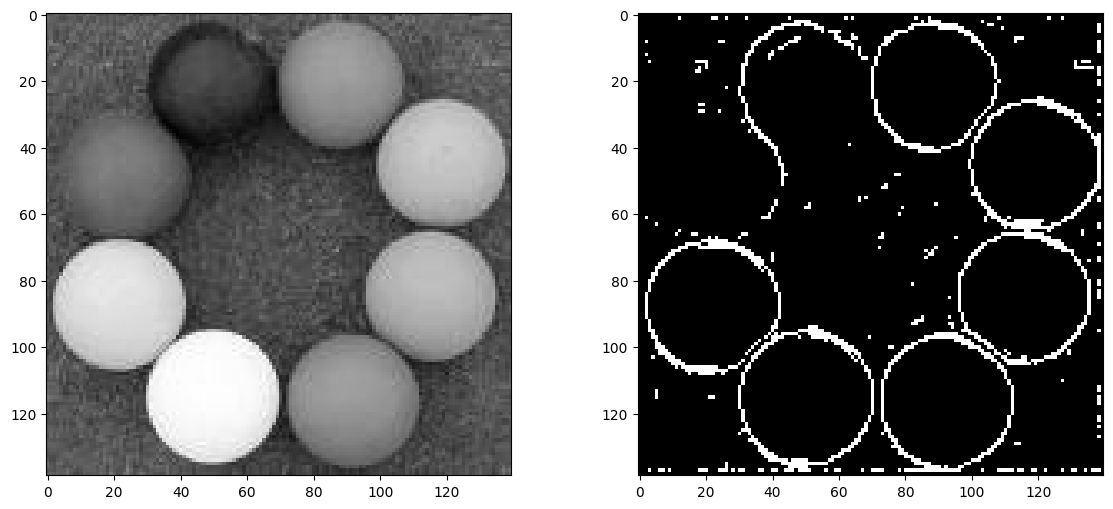

In [167]:
img1 = read_file(file_name='balls1.tiff') / 255
img1_e, tg_theta1 = edge_detect(img=img1, t_low=11/255, t_high=12/255)
plot_images(img1, img1_e)

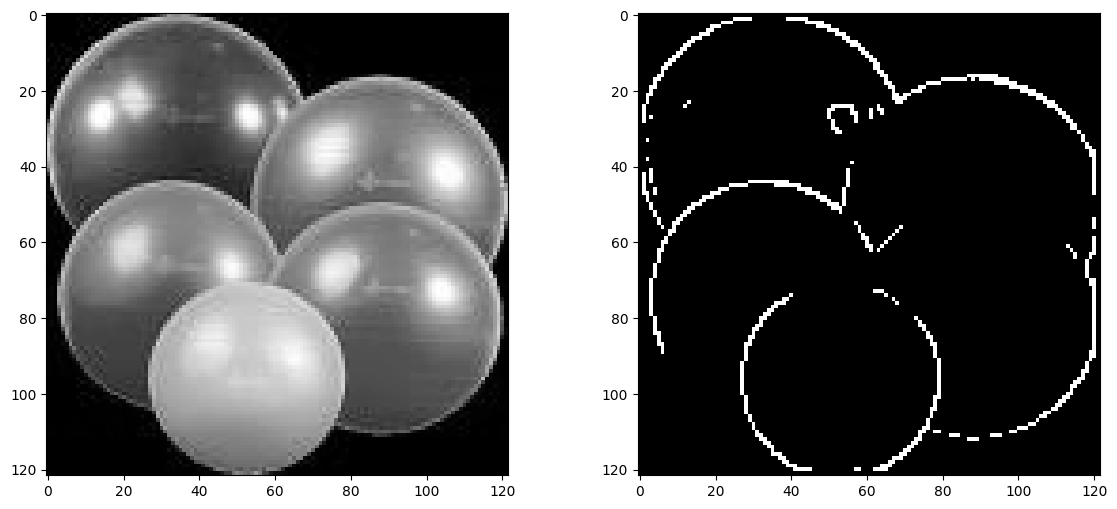

In [168]:
img4 = read_file(file_name='balls4.tiff') / 255
img4_e, tg_theta = edge_detect(img=img4, t_low=35/255, t_high=36/255)
plot_images(img4, img4_e)

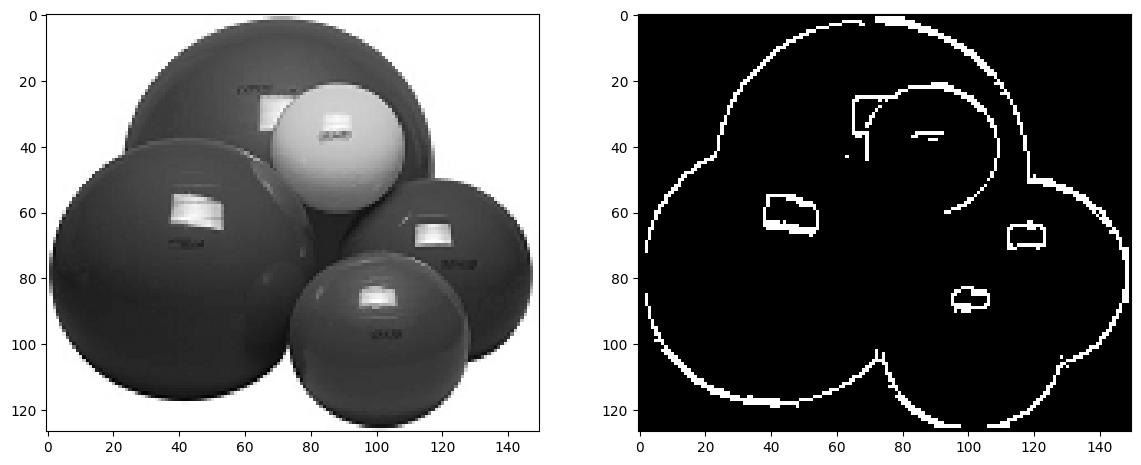

In [169]:
img5 = read_file(file_name='balls5.tiff') / 255
img5_e, tg_theta5 = edge_detect(img=img5, t_low=25/255, t_high=26/255)
plot_images(img5, img5_e)

## `find_circles`

In [170]:
def find_circles(img: np.array, t_low: np.float32, t_high: np.float32) -> (np.array, list):
    '''
    This function receives a grayscale image and finds circles in it using Hough
    transform.
    The function is using the edge_detect function on the given image before
    performing the Hough transform.
    It also uses the tg_theta array to improve the complexity of the algorithm.
    The function also returns a list of the found circles.

    Args:
        img:    image array in float format (range: 0..1) - the source grayscale
                image.
        t_low:  float format (range: 0..1), the Low threshold value.
        t_high: float format (range: 0..1), the High threshold value.

    Returns:
        img_c:   RGB image array in float format (range: 0..1) which contains
                    the original image and the marked circles which were found.
        circles: a list - each element represent a circle and contains a list of
                    3 values: origin_x, origin_y, radius
    '''
    # Step 1: Apply Edge Detection
    edges, tg_theta = edge_detect(img, t_low, t_high)
    # plot_images(edges, tg_theta)

    # # Sum of all values in the matrix
    # total_sum_edges = np.sum(edges)
    # print("Total sum edges:", total_sum_edges)

    # # Sum of all values in the matrix
    # total_sum_theta = np.sum(tg_theta)
    # print("Total sum theta:", total_sum_theta)

    # Step 2: Create the Count Matrix (centers(cx, cy) per radius (r) counters)
    r_min = 14
    r_max = min(img.shape) // 2
    img_nrows = img.shape[0]
    img_ncols = img.shape[1]
    count = np.zeros((img_ncols, img_nrows, r_max))

    # Scan edges matrix
    edges_nrows = edges.shape[0]
    edges_ncols = edges.shape[1]
    for y in range(edges_nrows):
        for x in range(edges_ncols):
            if edges[y, x] == 0:
                continue
            if abs(tg_theta[y, x]) <= 1:
                for cx in range(max(x - r_max, 0), min(x + r_max, img_ncols)):
                    cy = round(tg_theta[y, x] * (cx - x) + y)
                    r = round(np.sqrt((cx - x)**2 +(cy - y)**2))
                    if 0 < cy < img_nrows and 0 < r < r_max:
                        count[cx, cy, r] += 1
            else: # (abs(tg_theta[y,x]) > 1)
                for cy in range(max(y - r_max, 0), min(y + r_max, img_nrows)):
                    cx = round((cy-y)/tg_theta[y, x] + x)
                    r = round(np.sqrt((cx - x)**2 +(cy - y)**2))
                    if 0 < cx < img_ncols and 0 < r < r_max:
                        count[cx, cy, r] += 1

    # Step 3: Locate the Real Circles
    img_c = np.zeros_like(img)
    circles = []

    # Smooth the count matrix
    kernel = np.ones((5, 5, 5)) / 125  # 5x5x5 mean kernel
    smoothed_count = convolve(count, kernel, mode='same')

    # Set threshold
    threshold = r_max // 25

    # Perform Non-Max Suppression
    D = 15  # Neighborhood size
    for cx in range(img_ncols):
        for cy in range(img_nrows):
            for r in range(r_min, r_max):
                if smoothed_count[cx, cy, r] <= threshold:
                    continue

                neighbors = smoothed_count[max(cx - D, 1):min(cx + D, img_ncols),
                                           max(cy - D, 1):min(cy + D, img_nrows),
                                           max(r - D, r_min):min(r + D, r_max)]
                if smoothed_count[cx, cy, r] < np.max(neighbors):
                    continue

                circles.append([cx, cy, r])
                theta = 0
                while theta <= 2*np.pi:
                    pt = np.round(np.array([cx,cy]) + np.array([r*np.cos(theta),r*np.sin(theta)]))
                    irow = int(pt[1])
                    icol = int(pt[0])
                    if 0 < irow < img_nrows and 0 < icol < img_ncols:
                        img_c[irow, icol] = 1
                    theta = theta + 1/r

    return img_c, circles



[[41, 78, 40], [70, 48, 47], [89, 40, 20], [101, 99, 27], [120, 79, 28]]


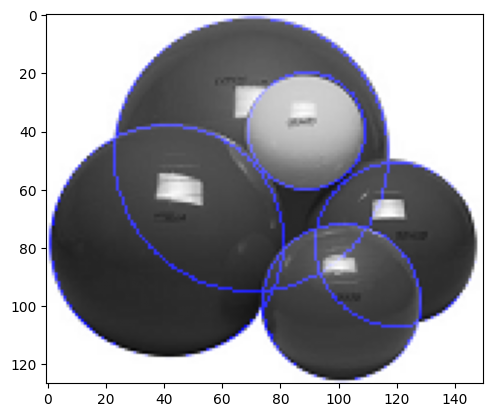

In [171]:
img = read_file(file_name='balls5.tiff') / 255
img_c, circles = find_circles(img=img, t_low=9/255, t_high=10/255)

img_rgb = np.dstack((img, img, img))
img_rgb[:,:,2] += img_c
img_rgb = img_rgb.clip(0,1)
plt.imshow(img_rgb);
print(circles)

[[33, 74, 30], [36, 37, 35], [53, 96, 26], [88, 81, 30], [89, 49, 32]]


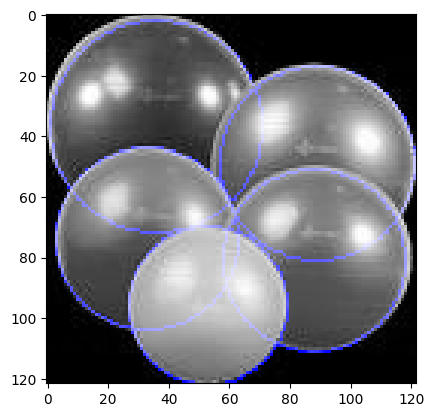

In [172]:
img = read_file(file_name='balls4.tiff') / 255
img_c, circles = find_circles(img=img, t_low=12/255, t_high=25/255)

img_rgb = np.dstack((img, img, img))
img_rgb[:,:,2] += img_c
img_rgb = img_rgb.clip(0,1)
plt.imshow(img_rgb);
print(circles)